In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data = pd.read_csv("../data/house_data.csv")
print(data.info())
# 去除有Nan的数据
tmp = data.dropna(axis=0, how="any")
print(tmp.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21613 non-null  float64
 1   bedrooms       21600 non-null  float64
 2   bathrooms      21603 non-null  float64
 3   sqft_living    21613 non-null  float64
 4   sqft_lot       21613 non-null  float64
 5   floors         21613 non-null  float64
 6   waterfront     21613 non-null  float64
 7   condition      21613 non-null  float64
 8   grade          21613 non-null  float64
 9   sqft_above     21613 non-null  float64
 10  sqft_basement  21613 non-null  float64
 11  yr_built       21613 non-null  float64
 12  lat            21613 non-null  float64
 13  long           21613 non-null  float64
 14  Unnamed: 14    21613 non-null  float64
dtypes: float64(15)
memory usage: 2.5 MB
None
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
fl

In [25]:
data = tmp.values.copy()
print(data.shape)
# 切割数据
y = data[:, 0]
x = data[:, 1:]
print(y.shape)
print(x.shape)
print(x[0, :])

(21597, 15)
(21597,)
(21597, 14)
[ 3.0000e+00  1.0000e+00  1.3400e+03  5.6500e+03  1.0000e+00  0.0000e+00
  3.0000e+00  7.0000e+00  1.1800e+03  0.0000e+00  1.9550e+03  4.7510e+01
 -1.2226e+02  1.9550e+03]


In [26]:
from sklearn import preprocessing

y = y.reshape(-1, 1)
print(y.shape)
data = preprocessing.MinMaxScaler().fit_transform(x)
label = preprocessing.MinMaxScaler().fit_transform(y)
np.savez("house_norm.npz", data=data, label=label)
print(data[0, :])

(21597, 1)
[0.0625     0.06666667 0.16193426 0.00574235 0.         0.
 0.5        0.4        0.08960177 0.         0.47826087 0.56451613
 0.21666667 0.47826087]


epoch : 0 train_loss: 0.004285838454961777, test_loss: 0.0006420764257200062
epoch : 1 train_loss: 0.000732473679818213, test_loss: 0.0006976258591748774
epoch : 2 train_loss: 0.0007448035175912082, test_loss: 0.0007444290677085519
epoch : 3 train_loss: 0.0008036860381253064, test_loss: 0.0006527704535983503
epoch : 4 train_loss: 0.0007897397154010832, test_loss: 0.0006528098601847887
epoch : 5 train_loss: 0.0008058231906034052, test_loss: 0.0009338585659861565
epoch : 6 train_loss: 0.0008046704460866749, test_loss: 0.0009781589033082128
epoch : 7 train_loss: 0.0007371988613158464, test_loss: 0.0006561512127518654
epoch : 8 train_loss: 0.0008722839411348104, test_loss: 0.0006532511906698346
epoch : 9 train_loss: 0.0007895741146057844, test_loss: 0.0006901936721988022
epoch : 10 train_loss: 0.0009002002188935876, test_loss: 0.0007259679841808975
epoch : 11 train_loss: 0.000823447946459055, test_loss: 0.0007418565801344812
epoch : 12 train_loss: 0.0008986997418105602, test_loss: 0.000681

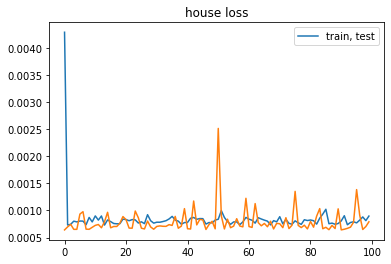

In [27]:
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
from torch.optim import Adam


class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torch.nn.Sequential(
            nn.Linear(in_features=14, out_features=32, bias=True),
            nn.BatchNorm1d(32),
            nn.Linear(in_features=32, out_features=64, bias=True),
            nn.BatchNorm1d(64),
            nn.Linear(in_features=64, out_features=32, bias=True),
            nn.BatchNorm1d(32),
            nn.Linear(in_features=32, out_features=16, bias=True),
            nn.BatchNorm1d(16),
            nn.Linear(in_features=16, out_features=8, bias=True),
            nn.BatchNorm1d(8),
            nn.Linear(in_features=8, out_features=4, bias=True),
            nn.BatchNorm1d(4),
            nn.Linear(in_features=4, out_features=1, bias=True),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


batch_size = 64
train_data_x, test_data_x = torch.utils.data.dataset.random_split(data, [17278, 4319],
                                                                  generator=torch.Generator().manual_seed(42))
train_data_y, test_data_y = torch.utils.data.dataset.random_split(label, [17278, 4319],
                                                                  generator=torch.Generator().manual_seed(42))
train_data = TensorDataset(torch.FloatTensor(train_data_x), torch.FloatTensor(train_data_y))
test_x, test_y = torch.FloatTensor(test_data_x), torch.FloatTensor(test_data_y)
train_data = DataLoader(
    dataset=train_data,
    batch_size=batch_size,
    shuffle=True
)
model = Model()
MSEloss = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.1)
max_epoch = 100


test_loss = []
train_loss = []
for epoch in range(max_epoch):
    epoch_loss = []
    for step, (batch_x, batch_y) in enumerate(train_data):
        pred = model(batch_x)
        loss = MSEloss(pred, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.cpu().data)
        #print(f"epoch: {epoch}, iter : {step}, loss: {loss.cpu().data}")
    test_pred = model(test_x)
    loss = MSEloss(test_pred, test_y)
    test_loss.append(loss.cpu().data)
    train_loss.append(np.mean(epoch_loss))
    print(f"epoch : {epoch} train_loss: {np.mean(epoch_loss)}, test_loss: {loss.cpu().data}")

plt.plot([i for i in range(max_epoch)], train_loss)
plt.plot([i for i in range(max_epoch)], test_loss)
plt.title("house loss")
plt.legend(["train, test"])
plt.show()

